# EEG-03 Solutions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

Today's demonstration will introduce time-frequency analysis of EEG data using `mne-python`. We will start by loading the epoched data from last session.

In [2]:
from mne import read_epochs

## Load data.
f = os.path.join('..','eeg-data','sub-01_task-audvis-epo.fif')
epochs = read_epochs(f, preload=True, verbose=False)

## Section 1: Frequency Analysis

As a rough first-pass, we can look at the frequency composition, collapsing across time, over the scalp topography.

Left Visual Stimuli


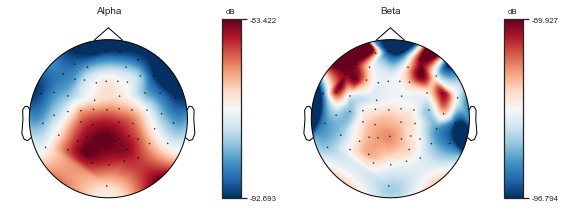

Right Visual Stimuli


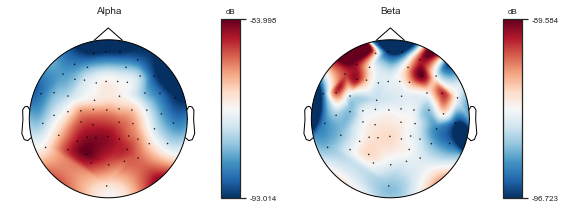

In [3]:
## Define frequency bands.
bands = [(8, 12, 'Alpha'), (12, 30, 'Beta')]

## Extract epochs.
LV = epochs['LV'].copy()
RV = epochs['RV'].copy()

## Iteratively plot.
print('Left Visual Stimuli')
fig, axes = plt.subplots(1,2,figsize=(8,4))
LV.plot_psd_topomap(bands, axes=axes, verbose=False);

print('Right Visual Stimuli')
fig, axes = plt.subplots(1,2,figsize=(8,4))
RV.plot_psd_topomap(bands, axes=axes, verbose=False);

## Section 2: Time-Frequency Decomposition

In this section, we will apply spectral decomposition to the visual evoked potentials from last class. Specifically, we will use Morlet wavelet decomposition to study the time-frequency composition of the evoked potentials.

First we need to define the parameters of the Morlet wavelet decomposition. This includes:

- *freqs*: frequencies of interest
- *n_cycles*: the number of cycles used for estimation, either globally or for each frequency

In [4]:
## Define parameters.
freqs = np.logspace(np.log(8), np.log(30), num=10, base=np.e) # Logarithmic sampling
n_cycles = 3

Next we will perform the decomposition for each condition separately.

In [5]:
from mne.time_frequency import tfr_morlet

## Extract epochs.
LV = epochs['LV'].copy()
RV = epochs['RV'].copy()

## Perform time-frequency decomposition.
LV_power = tfr_morlet(LV, freqs, n_cycles, average=True, return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=True, return_itc=False, verbose=False)

It is important to perform baseline correlations for time-frequency data. There are many methods for performing baseline correction. Here we will use the log-ratio technique:

$$ \text{decibel power} = 10 \times \log_{10}{\frac{\text{power}}{\text{baseline}}} $$

In [6]:
## Define parameters.
baseline = (-0.150, -0.050)
method = 'logratio'

## Apply baseline correction.
LV_power = LV_power.apply_baseline(baseline, 'logratio')
RV_power = RV_power.apply_baseline(baseline, 'logratio')

## Convert to decibels.
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Similar to ERP analysis, we can plot out the difference between conditions across the entire scalp.

No baseline correction applied


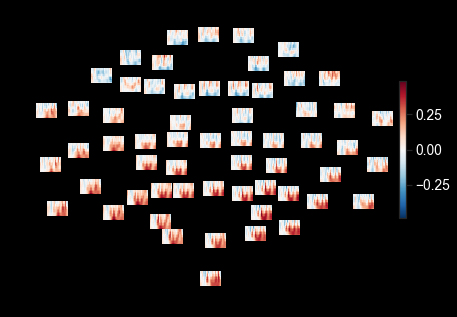

In [7]:
## Compute difference between conditions.
averageTFR = RV_power - LV_power

## Plot topographic difference.
averageTFR.plot_topo(baseline=None);

Now let's visualize the difference between the right and left visual stimulus presentation for a left posterior channel, EEG 057.

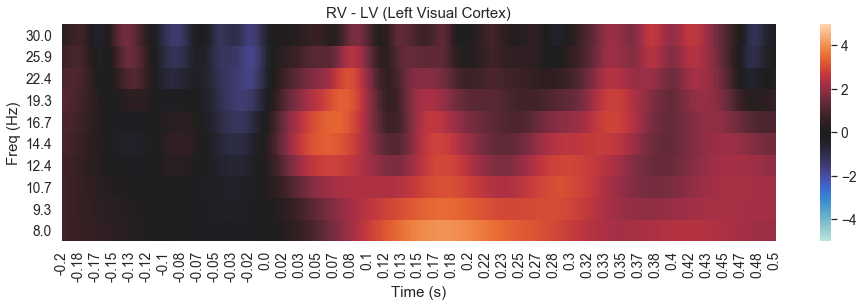

In [8]:
## initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(16,4))

## Compute difference.
diff = RV_power_arr[epochs.ch_names.index('EEG 057')] - LV_power_arr[epochs.ch_names.index('EEG 057')]

## Plotting.
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='RV - LV (Left Visual Cortex)')
ax.invert_yaxis()

## Section 3: Phase-Locked vs. Induced Power
To compute nonphase-locked power (also sometimes called “induced” activity), we must subtract the event-related potential (ERP) from single trials.

In [9]:
from mne.time_frequency import tfr_morlet

## Extract epochs.
LV = epochs['LV'].copy()
RV = epochs['RV'].copy()

## Subtracted evoked potential
LV = LV.subtract_evoked()
RV = RV.subtract_evoked()

## Perform time-frequency decomposition.
LV_power = tfr_morlet(LV, freqs, n_cycles, average=True, return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=True, return_itc=False, verbose=False)

Subtracting Evoked from Epochs
[done]
Subtracting Evoked from Epochs
[done]


It is important to perform baseline correlations for time-frequency data. There are many methods for performing baseline correction. Here we will use the log-ratio technique:

$$ \text{decibel power} = 10 \times \log_{10}{\frac{\text{power}}{\text{baseline}}} $$

In [10]:
## Define parameters.
baseline = (-0.150, -0.050)
method = 'logratio'

## Apply baseline correction.
LV_power = LV_power.apply_baseline(baseline, 'logratio')
RV_power = RV_power.apply_baseline(baseline, 'logratio')

## Convert to decibels.
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Now let's visualize the difference between the right and left visual stimulus presentation for a left posterior channel, EEG 057.

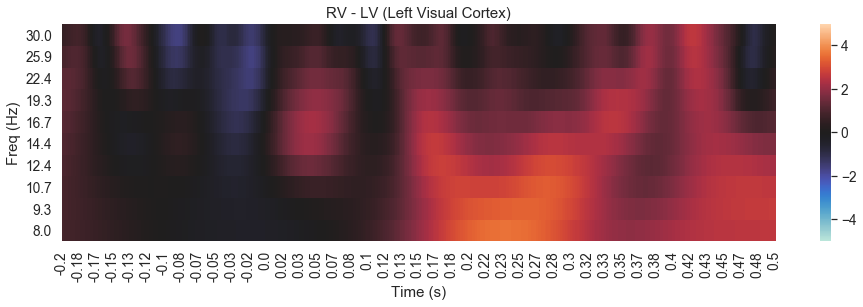

In [11]:
## initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(16,4))

## Compute difference.
diff = RV_power_arr[epochs.ch_names.index('EEG 057')] - LV_power_arr[epochs.ch_names.index('EEG 057')]

## Plotting.
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='RV - LV (Left Visual Cortex)')
ax.invert_yaxis()

## Section 4: Permutation Testing

Finally, we demonstrate 2d time-frequency permutation testing. Of course for permutation testing, we compute our statistics at the trial level. As such, we re-decompose our data this time at the trial level.

In [12]:
from mne.time_frequency import tfr_morlet

## Extract epochs.
LV = epochs['LV'].copy()
RV = epochs['RV'].copy()

## Subtracted evoked potential
LV = LV.subtract_evoked()
RV = RV.subtract_evoked()

## Perform time-frequency decomposition.
LV_power = tfr_morlet(LV, freqs, n_cycles, average=False, return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=False, return_itc=False, verbose=False)

## Apply baseline correction.
LV_power = LV_power.apply_baseline((-0.150, -0.050), 'logratio')
RV_power = RV_power.apply_baseline((-0.150, -0.050), 'logratio')

## Convert to decibels.
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Subtracting Evoked from Epochs
[done]
Subtracting Evoked from Epochs
[done]
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Now let's perform permutation testing. We above, we restrict our analysis to our channel of interest. We then pass both arrays, as a list, to `mne.stats.permutation_cluster_test`.

In [13]:
from mne.stats import permutation_cluster_test

## Limit to channel of interest (EEG 057).
ix = epochs.ch_names.index('EEG 057')
LV_power_057 = LV_power_arr[:,ix]
RV_power_057 = RV_power_arr[:,ix]

## Perform permutation testing.
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test([RV_power_057, LV_power_057], 
                                                           n_permutations=1024)

Using a threshold of 3.908741
stat_fun(H1): min=0.000000 max=15.403558
Running initial clustering
Found 16 clusters
Permuting 1023 times...
[                                        ]   0.00%  |   

<ipython-input-13-fadba3938ea9>:10: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=1024)


[........................................] 100.00%  |   
Computing cluster p-values
Done.


First let's visualize the clusters the permutation test detected.

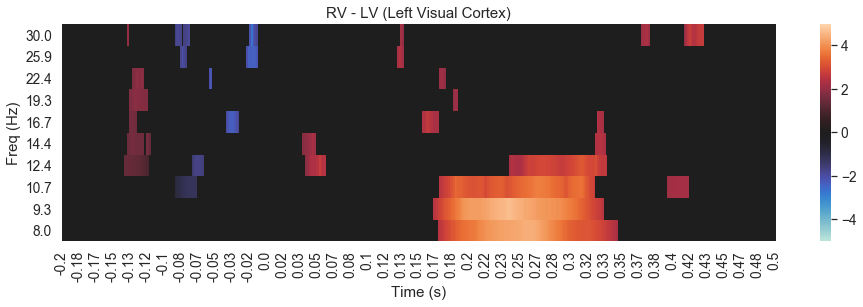

In [14]:
## initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(16,4))

## Compute difference.
diff = diff = RV_power_057.mean(axis=0) - LV_power_057.mean(axis=0)
diff *= np.sum(clusters, axis=0)

## Plotting.
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='RV - LV (Left Visual Cortex)')
ax.invert_yaxis()

Now let's threshold to only the significant clusters.

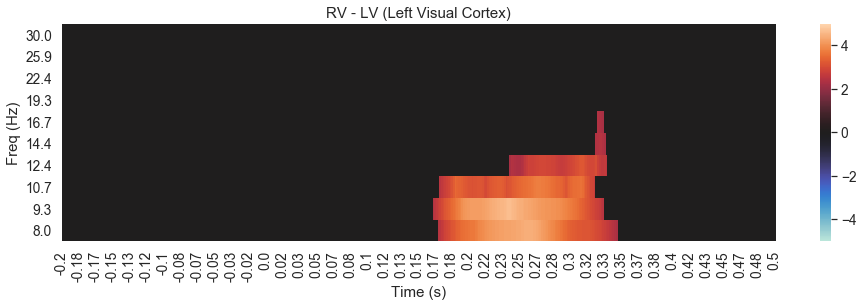

In [15]:
## initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(16,4))

## Compute difference.
diff = diff = RV_power_057.mean(axis=0) - LV_power_057.mean(axis=0)
diff *= np.sum([cluster if p < 0.05 else np.zeros_like(cluster) 
                for p, cluster in zip(cluster_pv, clusters)], axis=0)

## Plotting.
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='RV - LV (Left Visual Cortex)')
ax.invert_yaxis()